## Adversarial Autoencoder (Basic Implementation)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from components import AdversarialAutoencoder

## Dataset Configuration

In [2]:
def configure_mnist(batch_size=100):
    transform = transforms.Compose([
        transforms.ToTensor(), # [0,1 normalization]
        transforms.Lambda(lambda x : x.view(-1)) # [(n, d, d, 1) -> (n,d^2)]
    ])

    return DataLoader(
        datasets.MNIST(root='./data', train=True, transform=transform, download=True),
        batch_size=batch_size,
        shuffle=True
    )


## Paper Configuration

In [3]:
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM = 8
PRIOR_STD = 5.0
recon_loss = nn.MSELoss()
learning_rate = 1e-3 # not specified in appendix A.1, for successive experiments it is
use_decoder_sigmoid = True


## Training

In [4]:
aae = AdversarialAutoencoder(
    input_dim=INPUT_DIM,
    ae_hidden=AE_HIDDEN,
    dc_hidden=DC_HIDDEN,
    latent_dim=LATENT_DIM,
    recon_loss_fn=recon_loss,
    lr=learning_rate,
    use_decoder_sigmoid=use_decoder_sigmoid,
    device = "cuda" if torch.cuda.is_available() else "cpu"
)

loader = configure_mnist(batch_size=BATCH_SIZE)



In [ ]:
aae.train_mbgd(
    data_loader=loader,
    epochs=50,
    prior_std=PRIOR_STD,
)

## Evaluation

In [5]:
aae.load_weights()

Weights loaded from aae_weights_*.pth


Generated latent vectors shape: torch.Size([400, 8])


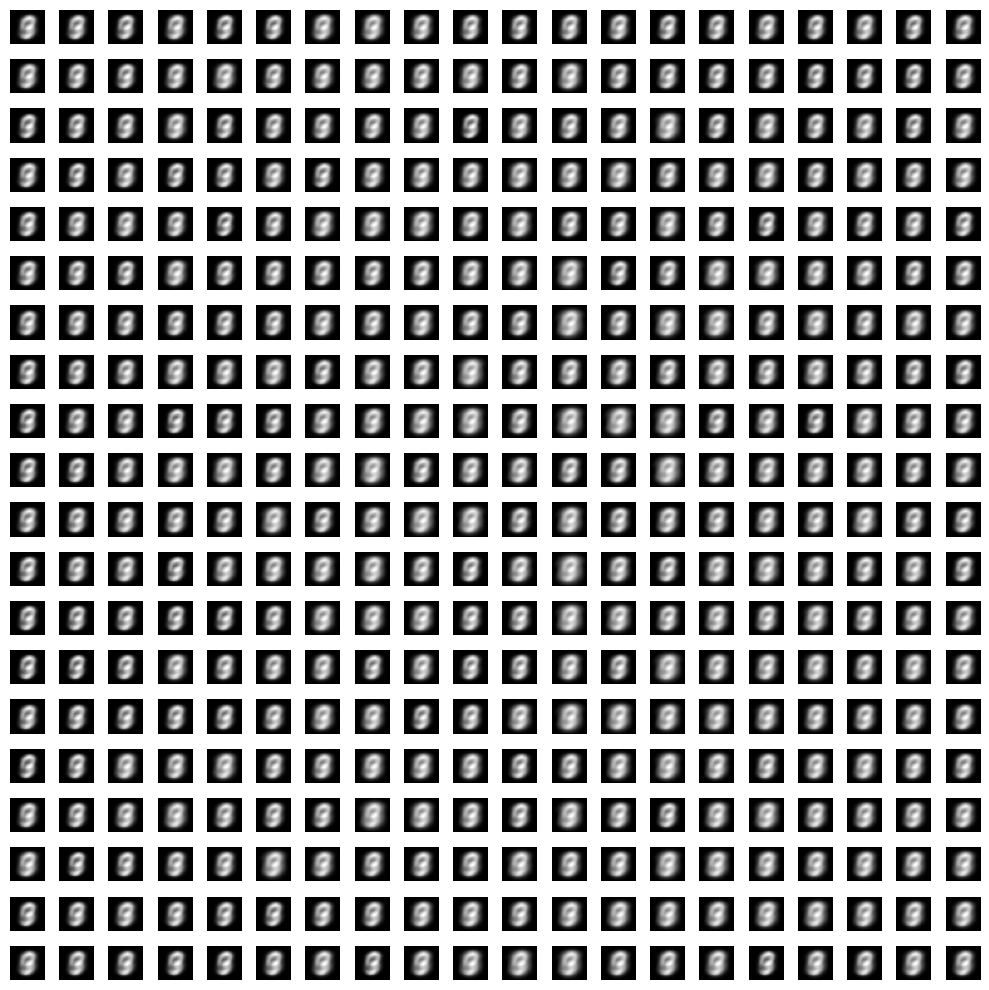

In [10]:
def plot_latent_traversal(aae, latent_dim, grid_size=20, latent_range=3, img_shape=(28, 28), prior_std=5.0):
    """
    Traverses a 2D slice of the latent space of a trained AAE and decodes samples for visualization.

    Args:
        aae: Trained AdversarialAutoencoder object (with .decoder and .device attributes).
        latent_dim: Dimensionality of the latent space.
        grid_size: Number of samples along each axis.
        latent_range: Number of standard deviations to traverse in each direction.
        img_shape: Shape of decoded image (e.g., (28, 28) for MNIST).
        prior_std: Standard deviation of the prior Gaussian distribution.
    """

    # Ensure evaluation mode
    aae.eval()

    # Create a 2D grid in the first two latent dimensions
    lin_space = np.linspace(-latent_range * prior_std, latent_range * prior_std, grid_size)
    z1, z2 = np.meshgrid(lin_space, lin_space)
    z_2d = np.stack([z1.ravel(), z2.ravel()], axis=-1)

    # If latent_dim > 2, sample the remaining dimensions from N(0, prior_std^2)
    if latent_dim > 2:
        extra_dims = np.random.normal(loc=0.0, scale=prior_std, size=(grid_size * grid_size, latent_dim - 2)).astype(np.float32)
        z_full = np.concatenate([z_2d, extra_dims], axis=1)
    else:
        z_full = z_2d.astype(np.float32)

    z_tensor = torch.tensor(z_full, dtype=torch.float32).to(aae.device)
    print(f"Generated latent vectors shape: {z_tensor.shape}")  # e.g., (400, latent_dim)

    # Decode latent vectors
    with torch.no_grad():
        decoded = aae.decoder(z_tensor).cpu().numpy()

    # Plot grid of generated images
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            img = decoded[i * grid_size + j].reshape(img_shape)
            ax.imshow(img, cmap="gray")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the latent space
plot_latent_traversal(aae, latent_dim=LATENT_DIM, grid_size=20, latent_range=3, img_shape=(28, 28))


In [ ]:
# Include likelihood experiments down here after.